In [2]:
import numpy as np
import pandas as pd
import Preprocess as Pre
import Logistic as LR
import random 
from multiprocessing import Pool
from statistics import mode
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
def split_dataset(all_data):
    test_data = all_data.sample(random_state = 47, frac = 0.2)
    train_data = all_data.drop(test_data.index)
    """
    This function will take in as input the whole dataset and you will have to program how to split the dataset into
    training and test datasets. These are the following requirements:
        -The function must take only one parameter which is all_data as a pandas dataframe of the raw dataset.
        -It must return 2 outputs in the specified order: train and test datasets
        
    It is up to you how you want to do the splitting of the data.
    """
    return train_data, test_data

"""
This function should not be changed at all.
"""
def eval(o_train, p_train, o_val, p_val, o_test, p_test):
    print('\nTraining Accuracy Result!')
    accuracy(o_train, p_train)
    print('\nTesting Accuracy Result!')
    accuracy(o_val, p_val)
    print('\nUnseen Test Set Accuracy Result!')
    accuracy(o_test, p_test)

"""
This function should not be changed at all.
"""
def accuracy(orig, pred):
    num = len(orig)
    if (num != len(pred)):
        print('Error!! Num of labels are not equal.')
        return
    match = 0
    for i in range(len(orig)):
        o_label = orig[i]
        p_label = pred[i]
        if (o_label == p_label):
            match += 1
    print('***************\nAccuracy: '+str(float(match) / num)+'\n***************')
    return float(match) / num

In [57]:
"""
You only need to implement bagging.
"""
import numpy as np
import Preprocess as Pre
import Logistic as LR
import random 
from multiprocessing import Pool
from statistics import mode 
import warnings
warnings.filterwarnings("ignore")

class Ensemble():
    def __init__(self):
        """
        You may initialize the parameters that you want and remove the 'return'
        """
        self.vocabulary = None
        self.weights = None
        self.bias = None
        self.n_gram_value = 1
        self.clf_list = []
        self.num_clf = None
        self.feature_method_extraction = 'unigram'
        # return
    
    def get_vocab(self, dataset, method):
        if method == 'unigram':
            self.vocabulary = Pre.build_vocab_n_gram(dataset, 1)
            self.n_gram_value = 1
        if method == 'bigram':
            self.vocabulary = Pre.build_vocab_n_gram(dataset, 2)
            self.n_gram_value = 2
        if method == 'trigram':
            self.vocabulary = Pre.build_vocab_n_gram(dataset, 3)
            self.n_gram_value = 3

    def feature_extraction(self, data, method=None):
        """
        Use the same method as in Logistic.py
        """
        df = []
        if method == 'unigram':
            
            for i in range(0, data.shape[0]):
                df.append(Pre.get_vector_n_gram(data.iloc[i]['Text'], self.vocabulary, self.n_gram_value))
            return np.array(df)
            # return

        if method == 'bigram':
            # df = []
            for i in range(0, data.shape[0]):
                df.append(Pre.get_vector_n_gram(data.iloc[i]['Text'], self.vocabulary, self.n_gram_value))
            return np.array(df)
            # return
        
        if method == 'trigram':
            # df = []
            for i in range(0, data.shape[0]):
                df.append(Pre.get_vector_n_gram(data.iloc[i]['Text'], self.vocabulary, self.n_gram_value))
            return np.array(df)
        # return
    
    # def predict_labels(self, data_point):
    #     """
    #     Optional helper method to produce predictions for a single data point
    #     """
    #     return

    def train(self, labeled_data, num_clf=31):
        """
        You must implement this function and it must take in as input data in the form of a pandas dataframe. 
        This dataframe must have the label of the data points stored in a column called 'Label'. For example, 
        the column labeled_data['Label'] must return the labels of every data point in the dataset. 
        Additionally, this function should not return anything.

        There is no limitation on how you implement the training process.
        """
        self.num_clf = num_clf
        self.get_vocab(labeled_data, self.feature_method_extraction)
        X, y = Pre.get_features_labels(labeled_data, 'Label')
        X = self.feature_extraction(X, self.feature_method_extraction)
        self.train_multiple_LR(X, y)
    
    def train_multiple_LR(self, X, y):
        np.random.seed(0)
        for k in range(self.num_clf):
            indices_taken = np.random.choice(np.arange(len(X)), size = len(X), replace = True)
            log = LR.Logistic()
            log.train_after_feature_extraction(X[indices_taken], y[indices_taken], max_epochs=100, reg_method='L2', lam=0.001, learning_rate=0.001)
            self.clf_list.append(log)

    def predict(self, data):
        predicted_labels = []
        """
        This function is designed to produce labels on some data input. The only input is the data in the 
        form of a pandas dataframe. 

        Finally, you must return the variable predicted_labels which should contain a list of all the predicted 
        labels on the input dataset. This list should only contain integers  that are either 0 (negative) or 
        1 (positive) for each data point.

        The rest of the implementation can be fully customized.
        """
        X, y = Pre.get_features_labels(data, 'Label')
        X = self.feature_extraction(X, self.feature_method_extraction)

        for feature in X:
            predicted_labels.append(self.predict_instance(feature))
        return predicted_labels
    
    def predict_instance(self, instance):
        bagging_list = []
        for classifier in self.clf_list:
            bagging_list.append(classifier.predict_labels(instance))
        return mode(bagging_list)

In [58]:
from Logistic import Logistic
from Ensemble import Ensemble
all_data = pd.read_csv('data.csv', index_col=0)
train_data, test_data = split_dataset(all_data)

# placeholder dataset -> when we run your code this will be an unseen test set your model will be evaluated on
test_data_unseen = pd.read_csv('test_data.csv', index_col=0)
train_acc = []
test_acc = []
num_clf = [1,5,11,31,51,101]
for num in num_clf:
    print("Current num:", num)
    ensemble = Ensemble()
    ensemble.train(train_data, num)
    predicted_train_labels_ensemble = ensemble.predict(train_data)
    predicted_test_labels_ensemble = ensemble.predict(test_data)
    train_acc.append(accuracy(train_data['Label'].tolist(), predicted_train_labels_ensemble))
    test_acc.append(accuracy(test_data['Label'].tolist(), predicted_test_labels_ensemble))
# predicted_test_labels_unseen_ensemble = ensemble.predict(test_data_unseen)



Current num: 1
Vocab generated
Current feature extraction method :  unigram
Currently training 0 LR model
Current method is : unigram
Current method is : unigram
***************
Accuracy: 0.9338235294117647
***************
***************
Accuracy: 0.8235294117647058
***************
Current num: 5
Vocab generated
Current feature extraction method :  unigram
Currently training 0 LR model
Currently training 1 LR model
Currently training 2 LR model
Currently training 3 LR model
Currently training 4 LR model
Current method is : unigram
Current method is : unigram
***************
Accuracy: 0.9683823529411765
***************
***************
Accuracy: 0.8676470588235294
***************
Current num: 11
Vocab generated
Current feature extraction method :  unigram
Currently training 0 LR model
Currently training 1 LR model
Currently training 2 LR model
Currently training 3 LR model
Currently training 4 LR model
Currently training 5 LR model
Currently training 6 LR model
Currently training 7 LR m

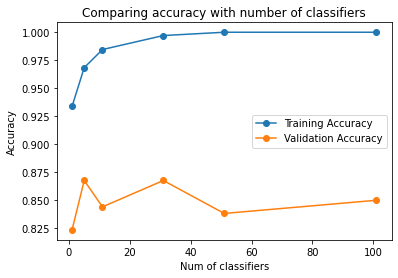

In [59]:
def plot_graph(num_clf, training_accuracy_list, testing_accuracy_list):
    plt.plot(num_clf, training_accuracy_list, label = "Training Accuracy", marker = 'o')
    plt.plot(num_clf, testing_accuracy_list, label = "Validation Accuracy", marker = 'o')
    
    plt.xlabel('Num of classifiers')
    plt.ylabel('Accuracy')
    plt.title('Comparing accuracy with number of classifiers')
    plt.legend()
    plt.show()
plot_graph(num_clf, train_acc, test_acc)

In [60]:
from Logistic import Logistic
from Ensemble import Ensemble

logistic = Logistic()
print("Training the LR model")
lambda_list = [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10]
train_acc_lambda=[]
test_acc_lambda = []
# lambda_list = [0.01]
for l in lambda_list:
    print("Current lambda:", l)
    logistic.train(train_data, lam=l, reg_method='L2')
    # print("Trained the LR model")
    predicted_train_labels_logistic = logistic.predict(train_data)
    # print("Predicted on trained data")
    predicted_test_labels_logistic = logistic.predict(test_data)
    # print("Predicted on test data")
    train_acc_lambda.append(accuracy(train_data['Label'].tolist(), predicted_train_labels_logistic))
    test_acc_lambda.append(accuracy(test_data['Label'].tolist(), predicted_test_labels_logistic))
    # predicted_test_labels_unseen_logistic = logistic.predict(test_data_unseen)

Training the LR model
Current lambda: 0.001
***************
Accuracy: 1.0
***************
***************
Accuracy: 0.861764705882353
***************
Current lambda: 0.005
***************
Accuracy: 1.0
***************
***************
Accuracy: 0.8588235294117647
***************
Current lambda: 0.01
***************
Accuracy: 0.9992647058823529
***************
***************
Accuracy: 0.8558823529411764
***************
Current lambda: 0.05
***************
Accuracy: 0.9816176470588235
***************
***************
Accuracy: 0.85
***************
Current lambda: 0.1
***************
Accuracy: 0.9433823529411764
***************
***************
Accuracy: 0.8352941176470589
***************
Current lambda: 1
***************
Accuracy: 0.774264705882353
***************
***************
Accuracy: 0.7
***************
Current lambda: 10
***************
Accuracy: 0.5345588235294118
***************
***************
Accuracy: 0.5264705882352941
***************


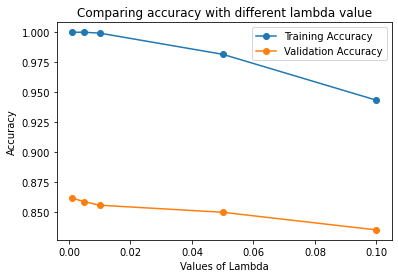

In [61]:
def plot_graph(num_clf, training_accuracy_list, testing_accuracy_list):
    plt.plot(num_clf, training_accuracy_list, label = "Training Accuracy", marker = 'o')
    plt.plot(num_clf, testing_accuracy_list, label = "Validation Accuracy", marker = 'o')
    
    plt.xlabel('Values of Lambda')
    plt.ylabel('Accuracy')
    plt.title('Comparing accuracy with different lambda value')
    plt.legend()
    plt.show()
plot_graph(lambda_list[:5], train_acc_lambda[:5], test_acc_lambda[:5])

In [27]:
"""
You may need to import necessary modules like numpy and pandas. However, you can't use any external
libraries such as sci-kit learn, etc. to implement logistic regression and the training of the logistic function.
The implementation must be done completely by yourself.

We are allowing you to use two packages from nltk for text processing: nltk.stem and nltk.tokenize. You cannot import
nltk in general, but we are allowing the use of these two packages only. We will check the code in your programs to
make sure this is the case and if other packages in nltk are used then we will deduct points from your assignment.
"""

"""
This is a Python class meant to represent the logistic model and any sort of feature processing that you may do. You 
have a lot of flexibility on how you want to implement the training of the logistic function but below I have listed 
functionality that should not change:
    - Arguments to the __init__ function 
    - Arguments and return statement of the train function
    - Arguments and return statement of the predict function 


When you want the program (logistic) to train on a dataset, the train function will only take one input which is the 
raw copy of the data file as a pandas dataframe. Below, is example code of how this is done:

    data = pd.read_csv('data.csv', index_col=0)
    model = Logistic()
    model.train(data) # Train the model on data.csv


It is assumed when this program is evaluated, the predict function takes one input which is the raw copy of the
data file as a pandas dataframe and produces as output the list of predicted labels. Below is example code of how this 
is done:

    data = pd.read_csv('data.csv', index_col=0)
    model = Logistic()
    predicted_labels = model.predict(data) # Produce predictions using model on data.csv

I have added several optional helper methods for you to use in building the pipeline of training the logistic function. 
It is up to your discretion on if you want to use them or add your own methods.
"""
import numpy as np
import Preprocess as Pre
import warnings
warnings.filterwarnings("ignore")

class Logistic():
    def __init__(self):
        """
        The __init__ function initializes the instance attributes for the class. There should be no inputs to this
        function at all. However, you can setup whatever instance attributes you would like to initialize for this
        class. Below, I have just placed as an example the weights and bias of the logistic function as instance
        attributes.
        """
        self.vocabulary = None
        self.weights = None
        self.bias = None
        self.n_gram_value = 2
        self.feature_method_extraction = None

    def get_vocab(self, dataset, method):
        if method == 'unigram':
            self.vocabulary = Pre.build_vocab_n_gram(dataset, 1)
            self.n_gram_value = 1
        if method == 'bigram':
            self.vocabulary = Pre.build_vocab_n_gram(dataset, 2)
            self.n_gram_value = 2
        if method == 'trigram':
            self.vocabulary = Pre.build_vocab_n_gram(dataset, 3)
            self.n_gram_value = 3

    def sigmoid(self, z):
	    return(1 / (1 + np.exp(-z)))

    def feature_extraction(self, data, method=None):
        """
        Optional helper method to code the feature extraction function to transform the raw dataset into a processed
        dataset to be used in training. You need to implement unigram, bigram and trigram.
        """
        df = []
        if method == 'unigram':
            
            for i in range(0, data.shape[0]):
                df.append(Pre.get_vector_n_gram(data.iloc[i]['Text'], self.vocabulary, self.n_gram_value))
            return np.array(df)
            # return

        if method == 'bigram':
            # df = []
            for i in range(0, data.shape[0]):
                df.append(Pre.get_vector_n_gram(data.iloc[i]['Text'], self.vocabulary, self.n_gram_value))
            return np.array(df)
            # return
        
        if method == 'trigram':
            # df = []
            for i in range(0, data.shape[0]):
                df.append(Pre.get_vector_n_gram(data.iloc[i]['Text'], self.vocabulary, self.n_gram_value))
            return np.array(df)
            # return

    def logistic_loss(self, predicted_label, true_label):
        """
        Optional helper method to code the loss function.
        """
        return -np.sum(np.dot(true_label, np.log(predicted_label)), np.dot(1-true_label, np.log(1-predicted_label)))
    
    def regularizer(self, method='L2', lam=0.001):
        """
        You need to implement at least L1 and L2 regularizer
        """
        if method == 'L1':
            return lam
        if method == 'L2':
            # print("In L2")
            return lam*self.weights

    # def stochastic_gradient_descent(self, data, labels):
    #     """
    #     Optional helper method to compute a gradient update for a single point.
    #     """
    #     return

    def stochastic_gradient_descent(self, data, error, reg_method, lam):
        """
        Optional helper method to compute a gradient update for a single point.
        """
        # print("Current regularizer: ", reg_method)
        regularise_value = self.regularizer(reg_method, lam)
        return np.dot(data, error) + regularise_value

    # def stochastic_gradient_descent(self, data, error):
    #     """
    #     Optional helper method to compute a gradient update for a single point.
    #     """
    #     # regularise_value = self.regularizer(reg_method, lam)
    #     return np.dot(data, error) 

    def update_weights(self, learning_rate, gradient):
        """
        Optional helper method to update the weights during stochastic gradient descent.
        """
        new_weights = learning_rate*gradient
        self.weights -= new_weights

    # def update_weights(self, new_weights):
    #     """
    #     Optional helper method to update the weights during stochastic gradient descent.
    #     """
    #     self.weights = new_weights

    # def update_bias(self, new_bias):
    #     """
    #     Optional helper method to update the bias during stochastic gradient descent.
    #     """
    #     self.bias = new_bias

    def update_bias(self, learning_rate, error):
        """
        Optional helper method to update the bias during stochastic gradient descent.
        """
        new_bias = np.dot(learning_rate,error)
        self.bias -= new_bias

    def predict_labels(self, data_point):
        """
        Optional helper method to produce predictions for a single data point
        """
        return np.round(self.sigmoid(np.dot(data_point, self.weights)))

    def train(self, labeled_data, learning_rate=0.001, max_epochs=100, lam=0.001, feature_method='unigram', reg_method='L2'):
        """
        You must implement this function and it must take in as input data in the form of a pandas dataframe. 
        This dataframe must have the label of the data points stored in a column called 'Label'. For example, 
        the column labeled_data['Label'] must return the labels of every data point in the dataset. 
        Additionally, this function should not return anything.
        
        'learning_rate' and 'max_epochs' are the same as in HW2. 'reg_method' represents the regularier, 
        which can be 'L1' or 'L2' as in the regularizer function. 'lam' is the coefficient of the regularizer term. 
        'feature_method' can be 'unigram', 'bigram' or 'trigram' as in 'feature_extraction' method. Once you find the optimal 
        values combination, update the default values for all these parameters.

        There is no limitation on how you implement the training process.
        """
        print("Lambda value:", lam)
        self.feature_method_extraction = feature_method
        self.get_vocab(labeled_data, feature_method)
        # print("Current feature extraction method : ", self.n_gram_value)
        # print("Vocab generated")
        X, y = Pre.get_features_labels(labeled_data, 'Label')
        X = self.feature_extraction(X, feature_method)
        print("Lambda value:", lam)

        self.train_after_feature_extraction(X, y, max_epochs, reg_method, lam, learning_rate)

        # self.weights = np.zeros(X.shape[1])
        # self.bias = 0

        # for step in range(0, max_epochs):
        #     # print("Current epoch : ", step)
        #     for idx, x_feature in enumerate(X):
        #         scores = np.dot(x_feature, self.weights) + self.bias
        #         prediction = self.sigmoid(scores)
        #         output_error_signal = prediction - y[idx]
        #         # gradient = self.stochastic_gradient_descent(x_feature, output_error_signal)
        #         # self.update_weights(learning_rate, gradient)
        #         # self.update_bias(learning_rate, output_error_signal)

        #         gradient = self.stochastic_gradient_descent(x_feature, output_error_signal, reg_method, lam)
        #         self.update_weights(learning_rate, gradient)
        #         self.update_bias(learning_rate, output_error_signal)

        #         # error = y[idx] - prediction
        #         # delta_grad = learning_rate * ((lam * np.dot(x_feature, error)) + np.sum(self.weights))
        #         # self.weights -= delta_grad/X.shape[1]
        #         # self.update_bias(learning_rate, error)
        # return
    
    def train_after_feature_extraction(self, X, y, max_epochs, reg_method, lam, learning_rate):
        self.weights = np.zeros(X.shape[1])
        self.bias = 0
        print("Lambda value:", lam)
        for step in range(0, max_epochs):
            # print("Current epoch : ", step)
            for idx, x_feature in enumerate(X):
                scores = np.dot(x_feature, self.weights) + self.bias
                prediction = self.sigmoid(scores)
                output_error_signal = prediction - y[idx]
                gradient = self.stochastic_gradient_descent(x_feature, output_error_signal, reg_method, lam)
                self.update_weights(learning_rate, gradient)
                self.update_bias(learning_rate, output_error_signal)
        return

    def predict(self, data):
        predicted_labels = []
        """
        This function is designed to produce labels on some data input. The only input is the data in the 
        form of a pandas dataframe. 

        Finally, you must return the variable predicted_labels which should contain a list of all the predicted 
        labels on the input dataset. This list should only contain integers  that are either 0 (negative) or 
        1 (positive) for each data point.

        The rest of the implementation can be fully customized.
        """
        X, y = Pre.get_features_labels(data, 'Label')
        # print("Current method is :", self.feature_method_extraction)
        X = self.feature_extraction(X, self.feature_method_extraction)

        for feature in X:
            predicted_labels.append(self.predict_labels(feature))
        return predicted_labels

In [28]:
# from Logistic import Logistic
from Ensemble import Ensemble

logistic = Logistic()
print("Training the LR model")
learning_rate_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05]
train_acc_learning_rate=[]
test_acc_learning_rate = []
# lambda_list = [0.01]
for l in learning_rate_list:
    print("Current learning rate:", l)
    logistic.train(train_data, learning_rate=l)
    # print("Trained the LR model")
    predicted_train_labels_logistic = logistic.predict(train_data)
    # print("Predicted on trained data")
    predicted_test_labels_logistic = logistic.predict(test_data)
    # print("Predicted on test data")
    train_acc_learning_rate.append(accuracy(train_data['Label'].tolist(), predicted_train_labels_logistic))
    test_acc_learning_rate.append(accuracy(test_data['Label'].tolist(), predicted_test_labels_logistic))
    # predicted_test_labels_unseen_logistic = logistic.predict(test_data_unseen)

Training the LR model
Current learning rate: 0.0001
Lambda value: 0.001
Lambda value: 0.001
Lambda value: 0.001
***************
Accuracy: 0.9801470588235294
***************
***************
Accuracy: 0.8588235294117647
***************
Current learning rate: 0.0005
Lambda value: 0.001
Lambda value: 0.001
Lambda value: 0.001
***************
Accuracy: 0.9992647058823529
***************
***************
Accuracy: 0.8558823529411764
***************
Current learning rate: 0.001
Lambda value: 0.001
Lambda value: 0.001
Lambda value: 0.001
***************
Accuracy: 1.0
***************
***************
Accuracy: 0.861764705882353
***************
Current learning rate: 0.005
Lambda value: 0.001
Lambda value: 0.001
Lambda value: 0.001
***************
Accuracy: 1.0
***************
***************
Accuracy: 0.8588235294117647
***************
Current learning rate: 0.01
Lambda value: 0.001
Lambda value: 0.001
Lambda value: 0.001
***************
Accuracy: 1.0
***************
***************
Accuracy: 0.8

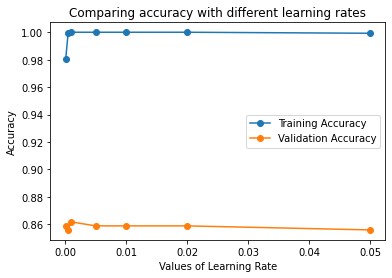

In [55]:
def plot_graph(num_clf, training_accuracy_list, testing_accuracy_list):
    plt.plot(num_clf, training_accuracy_list, label = "Training Accuracy", marker = 'o')
    plt.plot(num_clf, testing_accuracy_list, label = "Validation Accuracy", marker = 'o')
    
    plt.xlabel('Values of Learning Rate')
    plt.ylabel('Accuracy')
    plt.title('Comparing accuracy with different learning rates')
    plt.legend()
    plt.show()
plot_graph(learning_rate_list, train_acc_learning_rate, test_acc_learning_rate)

In [37]:
"""
You may need to import necessary modules like numpy and pandas. However, you can't use any external
libraries such as sci-kit learn, etc. to implement logistic regression and the training of the logistic function.
The implementation must be done completely by yourself.

We are allowing you to use two packages from nltk for text processing: nltk.stem and nltk.tokenize. You cannot import
nltk in general, but we are allowing the use of these two packages only. We will check the code in your programs to
make sure this is the case and if other packages in nltk are used then we will deduct points from your assignment.
"""

"""
This is a Python class meant to represent the logistic model and any sort of feature processing that you may do. You 
have a lot of flexibility on how you want to implement the training of the logistic function but below I have listed 
functionality that should not change:
    - Arguments to the __init__ function 
    - Arguments and return statement of the train function
    - Arguments and return statement of the predict function 


When you want the program (logistic) to train on a dataset, the train function will only take one input which is the 
raw copy of the data file as a pandas dataframe. Below, is example code of how this is done:

    data = pd.read_csv('data.csv', index_col=0)
    model = Logistic()
    model.train(data) # Train the model on data.csv


It is assumed when this program is evaluated, the predict function takes one input which is the raw copy of the
data file as a pandas dataframe and produces as output the list of predicted labels. Below is example code of how this 
is done:

    data = pd.read_csv('data.csv', index_col=0)
    model = Logistic()
    predicted_labels = model.predict(data) # Produce predictions using model on data.csv

I have added several optional helper methods for you to use in building the pipeline of training the logistic function. 
It is up to your discretion on if you want to use them or add your own methods.
"""
import numpy as np
import Preprocess as Pre
import warnings
warnings.filterwarnings("ignore")

class Logistic():
    def __init__(self):
        """
        The __init__ function initializes the instance attributes for the class. There should be no inputs to this
        function at all. However, you can setup whatever instance attributes you would like to initialize for this
        class. Below, I have just placed as an example the weights and bias of the logistic function as instance
        attributes.
        """
        self.vocabulary = None
        self.weights = None
        self.bias = None
        self.n_gram_value = 2
        self.feature_method_extraction = None

    def get_vocab(self, dataset, method):
        if method == 'unigram':
            self.vocabulary = Pre.build_vocab_n_gram(dataset, 1)
            self.n_gram_value = 1
        if method == 'bigram':
            self.vocabulary = Pre.build_vocab_n_gram(dataset, 2)
            self.n_gram_value = 2
        if method == 'trigram':
            self.vocabulary = Pre.build_vocab_n_gram(dataset, 3)
            self.n_gram_value = 3

    def sigmoid(self, z):
	    return(1 / (1 + np.exp(-z)))

    def feature_extraction(self, data, method=None):
        """
        Optional helper method to code the feature extraction function to transform the raw dataset into a processed
        dataset to be used in training. You need to implement unigram, bigram and trigram.
        """
        df = []
        if method == 'unigram':
            
            for i in range(0, data.shape[0]):
                df.append(Pre.get_vector_n_gram(data.iloc[i]['Text'], self.vocabulary, self.n_gram_value))
            return np.array(df)
            # return

        if method == 'bigram':
            # df = []
            for i in range(0, data.shape[0]):
                df.append(Pre.get_vector_n_gram(data.iloc[i]['Text'], self.vocabulary, self.n_gram_value))
            return np.array(df)
            # return
        
        if method == 'trigram':
            # df = []
            for i in range(0, data.shape[0]):
                df.append(Pre.get_vector_n_gram(data.iloc[i]['Text'], self.vocabulary, self.n_gram_value))
            return np.array(df)
            # return

    def logistic_loss(self, predicted_label, true_label):
        """
        Optional helper method to code the loss function.
        """
        return -np.sum(np.dot(true_label, np.log(predicted_label)), np.dot(1-true_label, np.log(1-predicted_label)))
    
    def regularizer(self, method='L2', lam=0.001):
        """
        You need to implement at least L1 and L2 regularizer
        """
        if method == 'L1':
            return lam
        if method == 'L2':
            # print("In L2")
            return lam*self.weights

    # def stochastic_gradient_descent(self, data, labels):
    #     """
    #     Optional helper method to compute a gradient update for a single point.
    #     """
    #     return

    def stochastic_gradient_descent(self, data, error, reg_method, lam):
        """
        Optional helper method to compute a gradient update for a single point.
        """
        # print("Current regularizer: ", reg_method)
        regularise_value = self.regularizer(reg_method, lam)
        return np.dot(data, error) + regularise_value

    # def stochastic_gradient_descent(self, data, error):
    #     """
    #     Optional helper method to compute a gradient update for a single point.
    #     """
    #     # regularise_value = self.regularizer(reg_method, lam)
    #     return np.dot(data, error) 

    def update_weights(self, learning_rate, gradient):
        """
        Optional helper method to update the weights during stochastic gradient descent.
        """
        new_weights = learning_rate*gradient
        self.weights -= new_weights

    # def update_weights(self, new_weights):
    #     """
    #     Optional helper method to update the weights during stochastic gradient descent.
    #     """
    #     self.weights = new_weights

    # def update_bias(self, new_bias):
    #     """
    #     Optional helper method to update the bias during stochastic gradient descent.
    #     """
    #     self.bias = new_bias

    def update_bias(self, learning_rate, error):
        """
        Optional helper method to update the bias during stochastic gradient descent.
        """
        new_bias = np.dot(learning_rate,error)
        self.bias -= new_bias

    def predict_labels(self, data_point):
        """
        Optional helper method to produce predictions for a single data point
        """
        return np.round(self.sigmoid(np.dot(data_point, self.weights)))

    def train(self, labeled_data, learning_rate=0.001, max_epochs=100, lam=0.001, feature_method='unigram', reg_method='L2'):
        """
        You must implement this function and it must take in as input data in the form of a pandas dataframe. 
        This dataframe must have the label of the data points stored in a column called 'Label'. For example, 
        the column labeled_data['Label'] must return the labels of every data point in the dataset. 
        Additionally, this function should not return anything.
        
        'learning_rate' and 'max_epochs' are the same as in HW2. 'reg_method' represents the regularier, 
        which can be 'L1' or 'L2' as in the regularizer function. 'lam' is the coefficient of the regularizer term. 
        'feature_method' can be 'unigram', 'bigram' or 'trigram' as in 'feature_extraction' method. Once you find the optimal 
        values combination, update the default values for all these parameters.

        There is no limitation on how you implement the training process.
        """
        # print("Lambda value:", lam)
        self.feature_method_extraction = feature_method
        self.get_vocab(labeled_data, feature_method)
        # print("Current feature extraction method : ", self.n_gram_value)
        # print("Vocab generated")
        X, y = Pre.get_features_labels(labeled_data, 'Label')
        X = self.feature_extraction(X, feature_method)
        # print("Lambda value:", lam)

        self.train_after_feature_extraction(X, y, max_epochs, reg_method, lam, learning_rate)

        # self.weights = np.zeros(X.shape[1])
        # self.bias = 0

        # for step in range(0, max_epochs):
        #     # print("Current epoch : ", step)
        #     for idx, x_feature in enumerate(X):
        #         scores = np.dot(x_feature, self.weights) + self.bias
        #         prediction = self.sigmoid(scores)
        #         output_error_signal = prediction - y[idx]
        #         # gradient = self.stochastic_gradient_descent(x_feature, output_error_signal)
        #         # self.update_weights(learning_rate, gradient)
        #         # self.update_bias(learning_rate, output_error_signal)

        #         gradient = self.stochastic_gradient_descent(x_feature, output_error_signal, reg_method, lam)
        #         self.update_weights(learning_rate, gradient)
        #         self.update_bias(learning_rate, output_error_signal)

        #         # error = y[idx] - prediction
        #         # delta_grad = learning_rate * ((lam * np.dot(x_feature, error)) + np.sum(self.weights))
        #         # self.weights -= delta_grad/X.shape[1]
        #         # self.update_bias(learning_rate, error)
        # return
    
    def train_after_feature_extraction(self, X, y, max_epochs, reg_method, lam, learning_rate):
        self.weights = np.zeros(X.shape[1])
        self.bias = 0
        # print("Lambda value:", lam)
        for step in range(0, max_epochs):
            # print("Current epoch : ", step)
            for idx, x_feature in enumerate(X):
                scores = np.dot(x_feature, self.weights) + self.bias
                prediction = self.sigmoid(scores)
                output_error_signal = prediction - y[idx]
                gradient = self.stochastic_gradient_descent(x_feature, output_error_signal, reg_method, lam)
                self.update_weights(learning_rate, gradient)
                self.update_bias(learning_rate, output_error_signal)
        return

    def predict(self, data):
        predicted_labels = []
        """
        This function is designed to produce labels on some data input. The only input is the data in the 
        form of a pandas dataframe. 

        Finally, you must return the variable predicted_labels which should contain a list of all the predicted 
        labels on the input dataset. This list should only contain integers  that are either 0 (negative) or 
        1 (positive) for each data point.

        The rest of the implementation can be fully customized.
        """
        X, y = Pre.get_features_labels(data, 'Label')
        # print("Current method is :", self.feature_method_extraction)
        X = self.feature_extraction(X, self.feature_method_extraction)

        for feature in X:
            predicted_labels.append(self.predict_labels(feature))
        return predicted_labels

In [38]:
# from Logistic import Logistic
logistic = Logistic()
print("Training the LR model")
epoch_list = [1,5,10,20,30,50,100,200]
train_acc_epoch = []
test_acc_epoch = []
# lambda_list = [0.01]
for l in epoch_list:
    print("Current epochs:", l)
    logistic.train(train_data, max_epochs=l)
    # print("Trained the LR model")
    predicted_train_labels_logistic = logistic.predict(train_data)
    # print("Predicted on trained data")
    predicted_test_labels_logistic = logistic.predict(test_data)
    # print("Predicted on test data")
    train_acc_epoch.append(accuracy(train_data['Label'].tolist(), predicted_train_labels_logistic))
    test_acc_epoch.append(accuracy(test_data['Label'].tolist(), predicted_test_labels_logistic))

Training the LR model
Current epochs: 1
***************
Accuracy: 0.850735294117647
***************
***************
Accuracy: 0.8029411764705883
***************
Current epochs: 5
***************
Accuracy: 0.9492647058823529
***************
***************
Accuracy: 0.861764705882353
***************
Current epochs: 10
***************
Accuracy: 0.9808823529411764
***************
***************
Accuracy: 0.8588235294117647
***************
Current epochs: 20
***************
Accuracy: 0.9933823529411765
***************
***************
Accuracy: 0.861764705882353
***************
Current epochs: 30
***************
Accuracy: 0.9970588235294118
***************
***************
Accuracy: 0.8588235294117647
***************
Current epochs: 50
***************
Accuracy: 1.0
***************
***************
Accuracy: 0.8588235294117647
***************
Current epochs: 100
***************
Accuracy: 1.0
***************
***************
Accuracy: 0.861764705882353
***************
Current epochs: 200
******

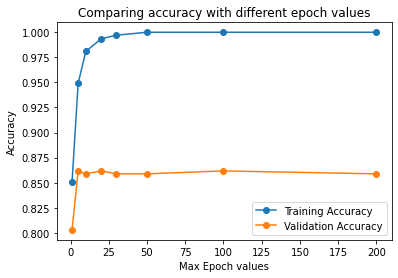

In [54]:
def plot_graph(num_clf, training_accuracy_list, testing_accuracy_list):
    plt.plot(num_clf, training_accuracy_list, label = "Training Accuracy", marker = 'o')
    plt.plot(num_clf, testing_accuracy_list, label = "Validation Accuracy", marker = 'o')
    
    plt.xlabel('Max Epoch values')
    plt.ylabel('Accuracy')
    plt.title('Comparing accuracy with different epoch values')
    plt.legend()
    plt.show()
plot_graph(epoch_list, train_acc_epoch, test_acc_epoch)

In [41]:
logistic = Logistic()
print("Training the LR model")
feature_method_list = ['unigram', 'bigram', 'trigram']
train_acc_feature_method = []
test_acc_feature_method = []
# lambda_list = [0.01]
for l in feature_method_list:
    print("Current feature method:", l)
    logistic.train(train_data, feature_method=l)
    # print("Trained the LR model")
    predicted_train_labels_logistic = logistic.predict(train_data)
    # print("Predicted on trained data")
    predicted_test_labels_logistic = logistic.predict(test_data)
    # print("Predicted on test data")
    train_acc_feature_method.append(accuracy(train_data['Label'].tolist(), predicted_train_labels_logistic))
    test_acc_feature_method.append(accuracy(test_data['Label'].tolist(), predicted_test_labels_logistic))

Training the LR model
Current feature method: unigram
***************
Accuracy: 1.0
***************
***************
Accuracy: 0.861764705882353
***************
Current feature method: bigram
***************
Accuracy: 0.9970588235294118
***************
***************
Accuracy: 0.7411764705882353
***************
Current feature method: trigram
***************
Accuracy: 0.9007352941176471
***************
***************
Accuracy: 0.6147058823529412
***************


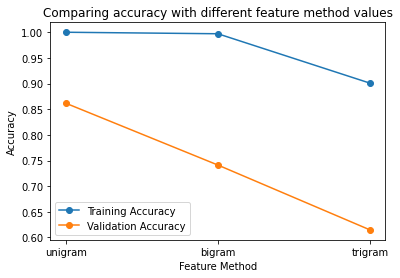

In [53]:
def plot_graph(num_clf, training_accuracy_list, testing_accuracy_list):
    plt.plot(num_clf, training_accuracy_list, label = "Training Accuracy", marker = 'o')
    plt.plot(num_clf, testing_accuracy_list, label = "Validation Accuracy", marker = 'o')
    
    plt.xlabel('Feature Method')
    plt.ylabel('Accuracy')
    plt.title('Comparing accuracy with different feature method values')
    plt.legend()
    plt.show()
plot_graph(feature_method_list, train_acc_feature_method, test_acc_feature_method)

In [48]:
import pandas as pd
import numpy as np
# import nltk
import string
import re
import nltk.stem
# from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

def remove_between_square_brackets(text):
  return re.sub('\[[^]]*\]', '', text)

def remove_special_characters(text, remove_digits=True):
  pattern=r'[^a-zA-z0-9\s]'
  text=re.sub(pattern,'',text) 
  return text

def tokenize_text(text):
    return [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]

def replace_text_stemming(text):
    stemmer = nltk.stem.PorterStemmer()
    stems = [stemmer.stem(word) for word in tokenize_text(text)]
    return " ".join(stems)
    
def get_features_labels(df, label_column_name):
    if 'Unnamed: 0' in df.columns:
        df.drop('Unnamed: 0', 1, inplace=True)
    labels = df[label_column_name]
    train_features = df.drop(label_column_name, 1)
    return train_features, labels.to_numpy()

def generate_N_grams(ngram, dataset):
  # text_corpus = "Firstly, word tokenization is done[89] where the 1100 stop words are ignored and the remaining words are retained."
    text_corpus = ""
    for i in range(0, dataset.shape[0]):
        text_corpus += " " + dataset.iloc[i]['Text']
    text_corpus = text_corpus.lower()
    text_corpus = remove_between_square_brackets(text_corpus)
    text_corpus = remove_special_characters(text_corpus, True)
    # print("COrpus now:", text_corpus)
    stemmed_corpus = replace_text_stemming(text_corpus)
    # print("COrpus now:", stemmed_corpus)
    # words=[word for word in text.split(" ") if word not in set(stopwords.words('english'))]  
    # print("Sentence after removing stopwords:",words)
    token=word_tokenize(stemmed_corpus)
    # print(type(token))
    stopwords_list = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
    token = [tok for tok in token if tok not in stopwords_list] 
    token = [tok for tok in token if tok not in string.punctuation]
    # for word in word_tokenize(sent):
    temp=zip(*[token[i:] for i in range(0,ngram)])
    ans=[' '.join(ngram) for ngram in temp]
    return ans

def get_word_count_n_gram(n_gram_token_list):
    word_count = {}
    for token in n_gram_token_list:
        if token in word_count:
            word_count[token]+=1
        elif token not in word_count:
            word_count[token]=1
    return word_count

def generate_N_grams_for_sent(ngram, sent):
    text_corpus = sent
    #   for i in range(0, dataset.shape[0]):
    #       text_corpus += " " + dataset.iloc[i]['Text']
    text_corpus = text_corpus.lower()
    text_corpus = remove_between_square_brackets(text_corpus)
    text_corpus = remove_special_characters(text_corpus, True)
    # print("COrpus now:", text_corpus)
    stemmed_corpus = replace_text_stemming(text_corpus)
    # print("COrpus now:", stemmed_corpus)
    # words=[word for word in text.split(" ") if word not in set(stopwords.words('english'))]  
    # print("Sentence after removing stopwords:",words)
    token=word_tokenize(stemmed_corpus)
    # print(type(token))
    stopwords_list = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
    token = [tok for tok in token if tok not in stopwords_list] 
    token = [tok for tok in token if tok not in string.punctuation]
    # for word in word_tokenize(sent):
    temp=zip(*[token[i:] for i in range(0,ngram)])
    ans=[' '.join(ngram) for ngram in temp]
    return ans

def get_vector_n_gram(text, vocabulary, n_gram_value):
    tokens = generate_N_grams_for_sent(n_gram_value, text)
    vector = np.zeros(len(vocabulary))
    for token in tokens:
        if token in vocabulary:
            vector[list(vocabulary.keys()).index(token)]+= 1
    return vector

def build_vocab_n_gram(dataset, n_gram_value):
    n_gram_tokens = generate_N_grams(n_gram_value, dataset)
    print("Token list length:", len(n_gram_tokens))
    vocab_n_gram_value = get_word_count_n_gram(n_gram_tokens)
    print("vocab length:", len(vocab_n_gram_value))
    updated_vocab_n_gram_value = {}
    min_freq = 0
    max_freq = 0
    if(n_gram_value==1):
        min_freq=17
        max_freq=20000
    if(n_gram_value==2):
        min_freq=5
        max_freq=200
    if(n_gram_value==3):
        min_freq=2
        max_freq=200
    for key in vocab_n_gram_value.keys():
        if(vocab_n_gram_value[key]>min_freq and vocab_n_gram_value[key]<max_freq):
            updated_vocab_n_gram_value[key] = vocab_n_gram_value[key]
    print("updated vocab length:",len(updated_vocab_n_gram_value))
    return updated_vocab_n_gram_value

In [50]:
all_data = pd.read_csv('data.csv', index_col=0)
train_data, test_data = split_dataset(all_data)
vocab_uni = build_vocab_n_gram(train_data, 1)

Token list length: 503029
vocab length: 26949
updated vocab length: 3879


In [51]:
vocab_bi = build_vocab_n_gram(train_data, 2)

Token list length: 503028
vocab length: 356157
updated vocab length: 6468


In [52]:
vocab_tri = build_vocab_n_gram(train_data, 3)

Token list length: 503027
vocab length: 485260
updated vocab length: 2443
